In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2
%load_ext cython

import csv
import sys, os, ctypes
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from numpy import genfromtxt
import itertools

from ipywidgets import IntProgress
from IPython.display import display, clear_output

In [2]:
# Turn a sequence of numbers into a debug friendly format
def stringify(b,spacer='', max=None):
    rtn = spacer.join(map(lambda x: '_' if x is None else str(int(x)), b))
    if max is not None and len(rtn) > max:
        return rtn[:max] + "..."
    return rtn
    
# Differential encodings cares about transitions not symbols; so
# we can take a modulated signal and just return how many symbols
# are in a row. 
def group_like(l):
    return [len(list(c)) for s, c in itertools.groupby(l)]

In [3]:
group_like([1, 1, 1, 1, 0, 0])

[4, 2]

In [4]:
%%cython
import numpy as np
cimport numpy as np
import cython

# We will use levenshtein edit distance as our error metric; but it's
# pretty slow in native python so we'll do it in cython and it's roughly
# as fast as a pure C implementation
@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
def levenshtein(np.ndarray s, np.ndarray t):
        ''' From Wikipedia article; Iterative with two matrix rows. '''
        cdef int is_eq = True
        cdef int len_s = len(s)
        cdef int len_t = len(t)
        cdef int i = 0
        cdef int j = 0
        cdef int cost = 0
        cdef long[:] _s = s;
        cdef long[:] _t = t;
        if len_s == len_t:
            for i in range(len_s):
                if _s[i] != _t[i]:
                    is_eq = False
                    break
            if is_eq:
                return 0
        elif len_s == 0: return len_t
        elif len_t == 0: return len_s
        _v0 = np.zeros((len_t + 1), dtype=np.int32)
        cdef int len_v0 = len(_v0)
        cdef int[:] v0 = _v0
        _v1 = np.zeros((len_t + 1), dtype=np.int32)
        cdef int[:] v1 = _v1
        for i in range(len(v0)):
            v0[i] = i
        for i in range(len_s):
            v1[0] = i + 1
            for j in range(len_t):
                cost = 0 if _s[i] == _t[j] else 1
                v1[j + 1] = min(v1[j] + 1, v0[j + 1] + 1, v0[j] + cost)
            for j in range(len_v0):
                v0[j] = v1[j]
                
        return v1[len_t]
levenshtein(np.array([1,0]), np.array([0,1]))

In [5]:
def conditional_reseed(seed):
    if seed is not None:
        np.random.seed(seed)
        
def make_data_stream(n, seed = None):
    conditional_reseed(seed)
    return np.random.randint(0, 2, size=n)

In [6]:
make_data_stream(50)

array([0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0])

In [16]:
# Encode a list of bits as per https://en.wikipedia.org/wiki/Differential_Manchester_encoding
def encode_diff_manchester(d, start = None, inv = 0):
    # start state doesn't matter; set it randomly to avoid relying on it below
    state = np.random.randint(0, 2) if start is None else start
    rtn = []
    
    for bit in d:
        if bit ^ inv:  
            rtn += [state, state]
            state = state ^ 1
        else:
            rtn += [state, state ^ 1]
    return rtn

In [17]:
ds = make_data_stream(25)
eds = encode_diff_manchester(ds)

print('This should stack transitions under every |, between the bars is the bit that generated the two bits below')
print(' ' + stringify(ds, ' | '))
print(stringify(eds, ' '))

This should stack transitions under every |, between the bars is the bit that generated the two bits below
 1 | 1 | 0 | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | 1 | 1 | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 1
1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0


In [9]:
# Take in a data stream and mimic sampling it at some supersampling factor `f`, 
# with random phase and frequency error. 
def make_sampled_stream(d, f, seed = None, f_error = .05, drift = .05):
    conditional_reseed(seed)
    inc = 1. / (f * np.random.uniform(1 - f_error, 1 + f_error))
    phase = np.random.rand() / 2.
    rtn = []
    # Faster to generate all these at once rather than in the loop
    phase_drifts = np.random.uniform(-drift/f, drift/f, size=math.ceil((1+len(d))*f))
    idx = 0
    while phase < len(d):
        this_floor = math.floor(phase)
        rtn.append(d[this_floor])
        phase += inc + phase_drifts[idx % len(phase_drifts)]
        idx+=1
    return rtn

In [18]:
f = 3
sampled_eds = make_sampled_stream(eds, f,seed=11)
print("With f=3, the sampled stream should ideally have three symbols perfectly for each modulated bit but random error has been added")
print('Data        |     ' + stringify(ds, '     |     '))
print('Modulated:  |  ' + stringify(eds, '  |  '))
print('Sampled:    |' + stringify(sampled_eds, ' '))

With f=3, the sampled stream should ideally have three symbols perfectly for each modulated bit but random error has been added
Data        |     1     |     1     |     0     |     1     |     0     |     1     |     0     |     0     |     0     |     0     |     0     |     1     |     0     |     0     |     0     |     1     |     1     |     1     |     0     |     1     |     0     |     0     |     0     |     0     |     1
Modulated:  |  1  |  1  |  0  |  0  |  1  |  0  |  1  |  1  |  0  |  1  |  0  |  0  |  1  |  0  |  1  |  0  |  1  |  0  |  1  |  0  |  1  |  0  |  1  |  1  |  0  |  1  |  0  |  1  |  0  |  1  |  0  |  0  |  1  |  1  |  0  |  0  |  1  |  0  |  1  |  1  |  0  |  1  |  0  |  1  |  0  |  1  |  0  |  1  |  0  |  0
Sampled:    |1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 

In [19]:
stringify(group_like(sampled_eds),' ')

'6 6 3 3 6 3 3 5 3 3 3 3 3 3 3 3 3 2 6 3 3 3 3 3 3 5 6 6 3 3 5 3 3 3 3 3 3 3 3 5'

In [20]:
def decode_sampled_diff_manchester(sampled, f):
    groups = group_like(sampled)
    read_since_output = 0
    grps_since_output = 0
    rtn = []
    for g in groups:
        read_since_output += g
        grps_since_output += 1
        
        if read_since_output >= math.ceil(1.5 * f):
            if grps_since_output == 2:
                rtn.append(0)
            elif grps_since_output == 1:
                rtn.append(1)
            # This shouldn't happen except for error; 
            # most likely guess is a '0'. 
            elif grps_since_output == 3:
                rtn.append(0)
            
            # We also don't handle the case where 'read_since_output' 
            # is too high -- if it's much more than 2 * f, that is 
            # likely an encoding error. This is sort of self correcting 
            # if we are out of phase; since we handle both errors by 
            # effectively dropping data it'll resync. 
            
            # For actual usage; probably throw in some indication of 
            # where the decodeing is valid / invalid. Later we'll use
            # edit distance which will sort this out for us.
            read_since_output = grps_since_output = 0
    return np.array(rtn)

In [27]:
# Generate `cnt` data streams of `size` length, encode, sample with noise, 
# demodulate and calculate the average error introduced into the decoded
# stream. 
def evaluate_f_error(f, size=500, seed=None, cnt=1000):
    err = 0
    for i in range(cnt):
        ds = make_data_stream(size)
        eds = encode_diff_manchester(ds)
        sampled_eds = make_sampled_stream(eds, f, f_error = .05, drift = .05)
        dsdf = np.array(decode_sampled_diff_manchester(sampled_eds, f))
        err += levenshtein(ds, dsdf)
    return err / cnt

def evaluate_fs(fs):
    progressBar = IntProgress(min=0, max=len(fs))
    display(progressBar)
    rtn = []
    for f in fs:
        progressBar.value += 1
        rtn.append(evaluate_f_error(f))
    print("Done!")
    return np.array(rtn)

In [28]:
# This takes a minute; go get a coffee or something
fs = np.arange(1., 5.25, .05)
%time fs_errors = evaluate_fs(fs)

IntProgress(value=0, max=85)

Done!
CPU times: user 3min 41s, sys: 42.5 ms, total: 3min 41s
Wall time: 3min 40s


<IPython.core.display.Javascript object>


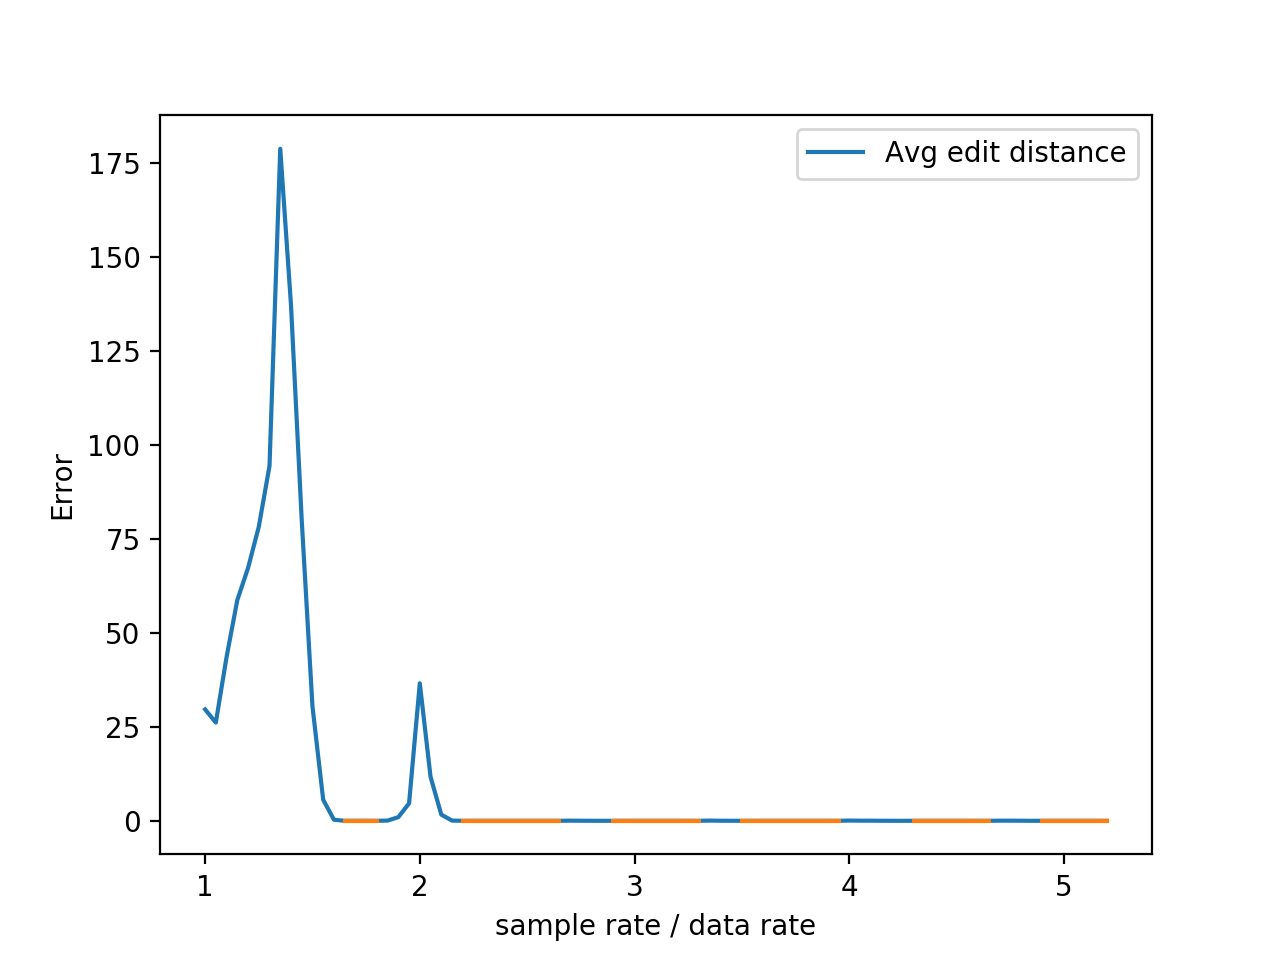

In [29]:
plt.figure()
plt.plot(fs, fs_errors, label="Avg edit distance")
perfect_fs = np.copy(fs)
perfect_fs[fs_errors > 0] = None
plt.plot(perfect_fs, fs_errors, '-')
plt.xlabel('sample rate / data rate')
plt.ylabel('Error')
plt.legend()